In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats

from causalgraphicalmodels import CausalGraphicalModel

import warnings

print('Running on pymc3 version {}'.format(pm.__version__))


warnings.filterwarnings('ignore')
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on pymc3 version 3.11.2


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

In [3]:
def standardize(array, reference=None):
    if reference is None:
        reference = array
    return (array - reference.mean()) / reference.std()

## Ex. 1

The first two problems are based on the same data. The data in data(foxes) are 116 foxes from 30 different urban groups in England. These fox groups are like street gangs. Group size (groupsize) varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some ter- ritories are larger than others. The area variable encodes this information. Some territories also have more avgfood than others. And food influences the weight of each fox. 

Use the backdoor criterion and estimate the total causal influence of A on F. What effect would increasing the area of a territory have on the amount of food inside it?

In [4]:
df = pd.read_csv('data/foxes.csv', sep=';')

In [5]:
df.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [6]:
#standardize values
df['avgfood_s'] = standardize(df['avgfood'])
df['area_s'] = standardize(df['area'])

Total causal influence means we do not need to stratify by any other variable in this case, given the dag. Therefore, the model definition is as follows: 

\begin{split}\begin{aligned}
F_i  &\sim Normal(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_A A_i \\
\alpha &\sim Normal(0, 0.5) \\
\beta_H &\sim Normal(0, 0.2) \\
\sigma &\sim Exponential(1)
\end{aligned}\end{split}




In [7]:
with pm.Model() as w_3_1:
    
    #define input data
    avgfood_s = pm.Data("avgfood_s", df['avgfood_s'])
    area_s = pm.Data("area_s", df['area_s'])

    #define priors
    alpha = pm.Normal("alpha", mu=0, sd=0.5)
    beta_a = pm.Normal("beta_a", mu=0, sd=0.2)
    sigma = pm.Exponential("sigma", 1)

    #define regression
    mu = pm.Deterministic("mu", alpha + beta_a*area_s)
    
    food_hat = pm.Normal("food_hat", mu=mu, sd=sigma, observed=avgfood_s)
    
    #prior sampling
    prior = pm.sample_prior_predictive()

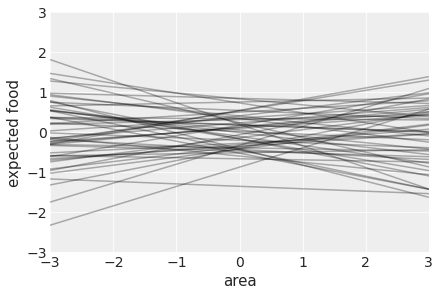

In [8]:
#simulate from priors

x = np.linspace(-3, 3, 30)

fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
ax.set_ylim(-3,3)
ax.set_xlabel('area')
ax.set_ylabel('expected food')

for a, b in zip(prior['alpha'][:50], prior['beta_a'][:50]):
    y = a + b*x
    plt.plot(x, y, color='black', alpha=0.3)  

In [9]:
with w_3_1:
    trace_3_1 = pm.sample(1000, tune=1000,return_inferencedata=False)
    posterior_3_1 = pm.sample_posterior_predictive(trace=trace_3_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_a, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [10]:
var_names = ['alpha', 'beta_a', 'sigma']

with w_3_1:
    summary = az.summary(trace_3_1, var_names=var_names)
summary    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.045,-0.086,0.083,0.001,0.001,5479.0,3166.0,1.0
beta_a,0.841,0.044,0.757,0.923,0.001,0.000,4316.0,2971.0,1.0
sigma,0.477,0.033,0.417,0.538,0.000,0.000,4885.0,3073.0,1.0


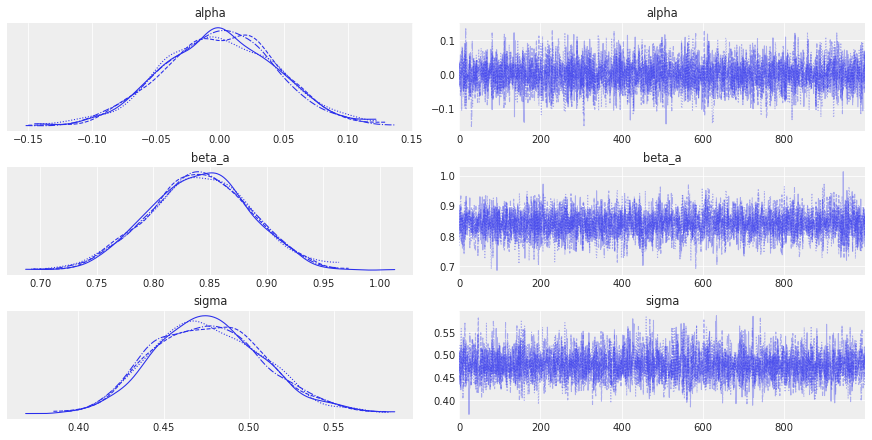

In [11]:
with w_3_1:
    az.plot_trace(trace_3_1, var_names=var_names)

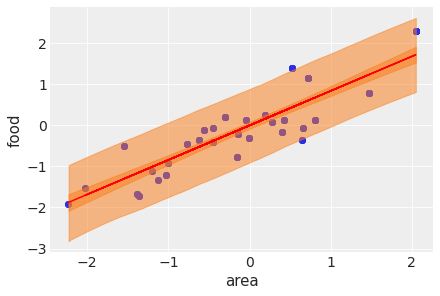

In [12]:
#plot sample
#plot posterior mean
#plot uncertainity of the mean
#plot uncertainity of the predictions

mu_mean = trace_3_1['mu'].mean(axis=0)

fig, ax = plt.subplots()
ax.set_xlabel('area')
ax.set_ylabel('food')
    
ax.scatter(df.area_s, df.avgfood_s) 
ax.plot(df.area_s, mu_mean, color = 'r')
az.plot_hdi(df.area_s, trace_3_1['mu'])
az.plot_hdi(df.area_s, posterior_3_1['food_hat']);

## Ex. 2

Now infer both the total and direct causal effects of adding food F to a territory on the weight W of foxes. Which covariates do you need to adjust for in each case? In light of your estimates from this problem and the previous one, what do you think is going on with these foxes? Feel free to speculate— all that matters is that you justify your speculation.

In [13]:
#standardize values
df['groupsize_s'] = standardize(df['groupsize'])
df['weight_s'] = standardize(df['weight'])

In [14]:
df.head()

,group,avgfood,groupsize,area,weight,avgfood_s,area_s,groupsize_s,weight_s
0,1,0.37,2,1.09,5.02,-1.924829,-2.239596,-1.524089,0.414135
1,1,0.37,2,1.09,2.84,-1.924829,-2.239596,-1.524089,-1.427046
2,2,0.53,2,2.05,5.33,-1.118035,-1.205508,-1.524089,0.675954
3,2,0.53,2,2.05,6.07,-1.118035,-1.205508,-1.524089,1.300942
4,3,0.49,2,2.12,5.85,-1.319734,-1.130106,-1.524089,1.115135


Model definition: total causal effect

\begin{split}\begin{aligned}
W_i  &\sim Normal(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_F F_i \\
\alpha &\sim Normal(0, 0.5) \\
\beta_F &\sim Normal(0, 0.2) \\
\sigma &\sim Exponential(1)
\end{aligned}\end{split}




In [64]:
with pm.Model() as w_3_2:
    
    #define input data
    avgfood_s = pm.Data("avgfood_s", df['avgfood_s'])
    weight_s = pm.Data("weight_s", df['weight_s'])

    #define priors
    alpha = pm.Normal("alpha", mu=0, sd=0.5)
    beta_f = pm.Normal("beta_f", mu=0, sd=0.2)
    sigma = pm.Exponential("sigma", 1)

    #define regression
    mu = pm.Deterministic("mu", alpha + beta_f*avgfood_s)
    
    weight_hat = pm.Normal("weight_hat", mu=mu, sd=sigma, observed=weight_s)
    
    #prior sampling
    prior = pm.sample_prior_predictive()

In [65]:
with w_3_2:
    trace_3_2 = pm.sample(1000, tune=1000,return_inferencedata=False)
    posterior_3_2 = pm.sample_posterior_predictive(trace=trace_3_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_f, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [66]:
var_names = ['alpha', 'beta_f', 'sigma']

with w_3_2:
    summary = az.summary(trace_3_2, var_names=var_names)
summary    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.095,-0.175,0.177,0.001,0.002,4851.0,2810.0,1.0
beta_f,-0.018,0.087,-0.182,0.142,0.001,0.001,4262.0,2721.0,1.0
sigma,1.010,0.070,0.884,1.139,0.001,0.001,5244.0,2687.0,1.0


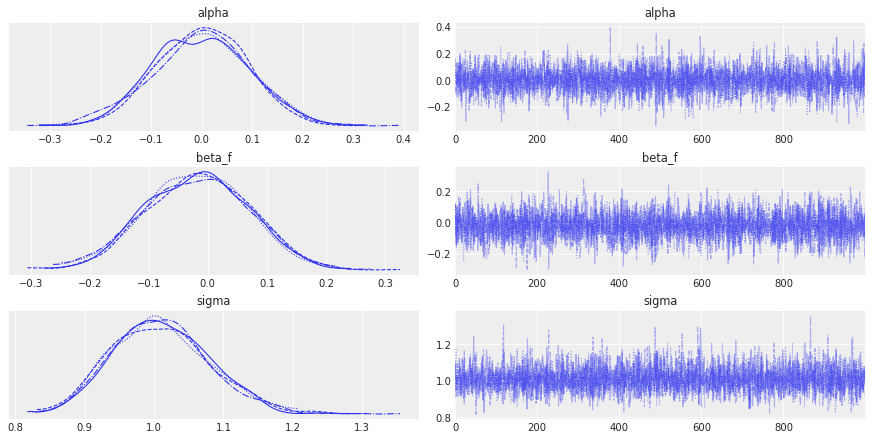

In [67]:
with w_3_2:
    az.plot_trace(trace_3_2, var_names=var_names)

Conclusion: we do not see a pronounced causal effect since beta_f is almost zero.

Model definition: direct effect
To understand the direct effect only, we need to include the group size variable.

\begin{split}\begin{aligned}
W_i  &\sim Normal(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_F F_i + \beta_G G_i \\
\alpha &\sim Normal(0, 0.5) \\
\beta_F &\sim Normal(0, 0.2) \\
\sigma &\sim Exponential(1)
\end{aligned}\end{split}



In [68]:
with pm.Model() as w_3_3:
    
    #define input data
    avgfood_s = pm.Data("avgfood_s", df['avgfood_s'])
    groupsize_s = pm.Data("groupsize_s", df['groupsize_s']) 
    weight_s = pm.Data("weight_s", df['weight_s'])

    #define priors
    alpha = pm.Normal("alpha", mu=0, sd=0.5)
    beta_f = pm.Normal("beta_f", mu=0, sd=0.2)
    beta_g = pm.Normal("beta_g", mu=0, sd=0.2)

    sigma = pm.Exponential("sigma", 1)

    #define regression
    mu = pm.Deterministic("mu", alpha + beta_f*avgfood_s + beta_g*groupsize_s)
    
    weight_hat = pm.Normal("weight_hat", mu=mu, sd=sigma, observed=weight_s)
    
    #prior sampling
    prior = pm.sample_prior_predictive()

In [69]:
with w_3_3:
    trace_3_3 = pm.sample(1000, tune=1000,return_inferencedata=False)
    posterior_3_3 = pm.sample_posterior_predictive(trace=trace_3_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_g, beta_f, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [72]:
var_names = ['alpha', 'beta_f', 'beta_g', 'sigma']

with w_3_3:
    summary = az.summary(trace_3_3, var_names=var_names)
summary    

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.089,-0.155,0.181,0.002,0.001,3061.0,2501.0,1.0
beta_f,0.175,0.127,-0.049,0.434,0.003,0.002,2489.0,2582.0,1.0
beta_g,-0.262,0.128,-0.501,-0.024,0.003,0.002,2420.0,2543.0,1.0
sigma,0.980,0.067,0.852,1.101,0.001,0.001,3064.0,2324.0,1.0


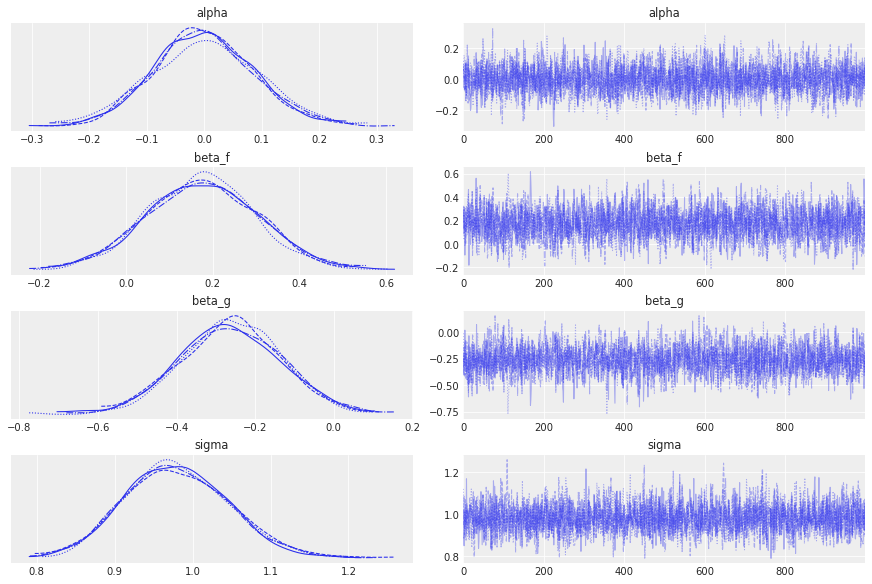

In [73]:
with w_3_3:
    az.plot_trace(trace_3_3, var_names=var_names)

Now we see that food has positive effect on weight, but the effect of group size is negative.

Possible explanation: the group size effect on weight which is negative is partially hiding the food effect when we are only exploring the total effect.
